## Masterclass ML 1
Déroulement d'un projet dans le domaine de la vente en ligne  

Cet masterclass est destinée à montrer le déroulement d'un projet de Data Science et d'illuster les différentes étapes.  

Ici, nous allons nous placer dans la peau d'un site de e-commerce. Notre problématique est simple: améliorer les ventes. Elle est simple mais elle est aussi très large... Que veut dire améliorer les ventes?  

Lorsque l'on définit une telle problématique à résoudre, il est intéressant de se poser la question des données à disposition: à quelles données ai-je accès (en interne ou en open data)? Si mes données ne sont pas suffisantes, comment puis-je les compléter (acheter des données, trouver des jeux libres d'accès sur internet, constituer soi-même des jeux de données supplémentaires avec du scraping par exemple, ...)? Est-ce que je connais ce que les données signifient? Et si non, qui peut me renseigner? Comment ces données ont été constituée? Quand l'ont-elles été? Est-ce que ces données sont de qualité?

Ici, nous n'allons pas essayer de répondre à ces questions mais elles sont essentielles pour proposer des modèles pertinents tout en connaissant les limites de ce modèle. Le jeu de données utilisé ici est nommé events.csv et contient une liste d'événements sur un site de e-commerce. Il fait partie d'un ensemble plus complexes de données disponible ici.  

### Description des données  
Les variables contenues dans ce jeu de données sont:  
- timestamp: timestamp représentant la date et l'heure à laquelle a eu lieu l'événement.
- visitorid: nombre qui représente un unique visiteur du site acteur de l'événement.
- event: nature de l'événement. Peut être de 3 types différents: "view", "addtocart", "transaction" qui correspondent à la vue d'un objet, son ajout au panier ou son achat.
- itemid: nombre qui représente un unique produit concerné par l'événement.
- transactionid: nombre qui représente une transaction unique  

Une des premières choses à faire est de faire l'inventaire du nombre de produits, du nombre de visiteurs, du nombre d'événements, ...  

Dans cet masterclass, nous ne nous attachons pas tant à la forme qu'au fond: parfois les solutions aux questions seront plus élaborées que ce que demandait la question. On peut obtenir les réponses aux questions de manière plus simple que ce que nous proposons comme réponses mais nos solutions sont ici des alternatives intéressantes pour aller plus loin dans les détails.   

Explorer et vérifier la qualité des données : Valeurs uniques, Valeurs manquantes, cohérences ...
À partir de ce jeu de données, trouver des pistes qui potentiellement permettront d'améliorer les affaires du site e-commerce.

In [1]:
import pandas as pd
from matplotlib import pyplot as plt
import numpy as np
import seaborn as sns

In [57]:
df = pd.read_csv('events.csv')

In [3]:
# préparation de l'affichage des dataframes

dico_pd_option = {
    'display.max_rows': 100,    # nbre max de lignes 
    'display.max_column': 50,  # nbre max de colonnes
    'display.width': 50,       # largeur lignes 
    'display.precision': 2,     # precision des valeurs
    'display.max_colwidth': 50  # largeurs colonnes
}
for cle, val in dico_pd_option.items():
    pd.set_option(cle, val) 
    
    
def desc_var(dataframe):
    """
    Retourne la description des variables qualitatives/quantitatives
    ou toutes les variables du dataframe transmis :
    type, nombre de nan, % de nan et desc
    Parameters
    ----------
    @param IN : dataframe : DataFrame, obligatoire

    @param OUT : dataframe de description des variables
    """
    df_taille = dataframe.shape[0]
    # sélection de tous les types de variable dans describe()
    desc_var = dataframe.describe(include='all')
    # dataframe des types des colonnes transposé en ligne pour lecture finale
    desc_type = pd.DataFrame(dataframe[desc_var.columns].dtypes, columns=['type']).T 
    # série du nombre de NaN par colonnes transposé en ligne pour df desc_nan ensuite
    nb_nan = df_taille - desc_var.loc['count'].T
    # série de calcul du %age de NaN par colonnes sur la série nb_nan
    pourcentage_nan = nb_nan * 100 / df_taille
    # dataframe de 2 lignes 'nb_nan' = serie nb_nan et '%nan'=serie pourcentage_nan
    desc_nan = pd.DataFrame([nb_nan, pourcentage_nan], index=['nb_nan', '%_nan']) 
    # fusion de tous les dataframe créés
    desc_var = pd.concat([desc_type, desc_nan, desc_var])
    return desc_var

# description des données
desc_var(df)

,timestamp,visitorid,event,itemid,transactionid
type,int64,int64,object,int64,float64
nb_nan,0.0,0.0,0.0,0.0,2733644.0
%_nan,0.0,0.0,0.0,0.0,99.19
count,2756101.0,2756101.0,2756101,2756101.0,22457.0
unique,NaN,NaN,3,NaN,NaN
top,NaN,NaN,view,NaN,NaN
freq,NaN,NaN,2664312,NaN,NaN
mean,1436424488348.14,701922.88,NaN,234922.48,8826.5
std,3366312180.01,405687.52,NaN,134195.43,5099.0
min,1430622004384.0,0.0,NaN,3.0,0.0


### Analyse 1
- df très long en lignes 2.7 millions et que 5 colonnes sans target évidente => modele lent en calculset et quoi prédire ?
    - => refaire un df + simple et adapté
- itemid :  beaucoup trop de catégories
    - quels sont les produits qui reviennent le + ?
- transactionId : beaucoup de NaN  mais en fait correspondent à des non-transaction ( à vérifier )
- timestamps : utilisables ? a retravailler, analyse temporelle ? format date ?
- visitorid : pas d'info sur le comportement ?
    - id identiques : plusieurs achats, analyse du comportement
    - value_counts -> beaucoup d'uniques, des milliers de fois parfois, réencodage ?
- event : nombre de 'view' important par rapport à "addtocart" et "transaction" => rééchantillonnage ?
    - get_dummies : s'il y a addtocart ( ajouter au pânier) il y a vue ?  suppirmer ? analyser à part des vues et il y aurait que 2 catégories ( celles vues-non-achetées et celles vues-achetées )
- value_counts indique que + un item est vu, + il est acheté
- duplicated ?
- se concentrer sur les visiteur : agregation = nbre de fois vue, quel item ?  => on ne fera pas cela mais intéressant !

### analyse Lara
- jeu de donnée super étroit -> restructurer
- jeu de données tres long -> restructurer
- fréquence des visitorid : est ce qu'ils focnt beaucoup de transaction ?
- itemid : quels sont ceux qui ont le + de transactions ? + ceux qui étaient beaucoup vus, beaucoup mis au panier ? ...
- timestamp : convertir la variable
- transactionid : que des Nan ? est ce plutot une absence de transaction ? doublons ? verifier nulle pour les vues + addtocart
- value_counts sur visitorid
- event :view en majorité, puis ajout au panier, transaction assez faible

In [5]:
print(df.info(show_counts=True), end="\n\n")
print("Taille du dataframe", df.shape, end='\n\n')
print(df.event.value_counts(normalize=True))

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2756101 entries, 0 to 2756100
Data columns (total 5 columns):
 #   Column         Non-Null Count    Dtype  
---  ------         --------------    -----  
 0   timestamp      2756101 non-null  int64  
 1   visitorid      2756101 non-null  int64  
 2   event          2756101 non-null  object 
 3   itemid         2756101 non-null  int64  
 4   transactionid  22457 non-null    float64
dtypes: float64(1), int64(3), object(1)
memory usage: 105.1+ MB
None

Taille du dataframe (2756101, 5)

view           9.67e-01
addtocart      2.52e-02
transaction    8.15e-03
Name: event, dtype: float64


### suppression des duplicated

In [22]:
# duplicated ?
nb_lignes_dupliquees = df.duplicated().sum()  # sum() de serie bool
print("nombre de lignes dupliquées :", nb_lignes_dupliquees)

nombre de lignes dupliquées : 460


In [58]:
# effacement lignes dupliquées
df.drop_duplicates(inplace=True)
df.shape

(2755641, 5)

### analyse des NaN pour décision

In [59]:
# verif des NaN sur la seule colonne 'transactionid'
print("NaN sur tout le df (2755641, 5) :",df.isna().sum())

NaN sur tout le df (2755641, 5) : timestamp              0
visitorid              0
event                  0
itemid                 0
transactionid    2733184
dtype: int64


In [60]:
# vérif si ces NaN ne correspondent pas à l'absence de transaction sur la variable 'event'
# on convertit transactionid en 0 si nan et 1 sinon, puis on fait un tableau croisé
print(pd.crosstab(df.event, np.where(df.transactionid.isna(), 0, 1)))  

col_0              0      1
event                      
addtocart      68966      0
transaction        0  22457
view         2664218      0


- on voit qu'il y a exactement 22457 transaction réalisées qui sont non NaN donc on garde les NaN car info vue ou mis dans panier sauf si achat réalisé !

### analyse du datime bizarre 'timestamp' = 1430622004384 ...
- utiliser to_datetime pour la transformer en type date

In [61]:
pd.to_datetime(df.timestamp)  # pb unité de temps car tout en 1970-01-01 sur 5 min => impossible !!!

0         1970-01-01 00:23:53.221332117
1         1970-01-01 00:23:53.224214164
2         1970-01-01 00:23:53.221999827
3         1970-01-01 00:23:53.221955914
4         1970-01-01 00:23:53.221337106
                       ...             
2756096   1970-01-01 00:23:58.398785939
2756097   1970-01-01 00:23:58.399813142
2756098   1970-01-01 00:23:58.397820527
2756099   1970-01-01 00:23:58.398530703
2756100   1970-01-01 00:23:58.400163914
Name: timestamp, Length: 2755641, dtype: datetime64[ns]

In [62]:
pd.to_datetime(df.timestamp, unit='ms')  # juste pour voir => unit='ms' est la bonne unité !!!

0         2015-06-02 05:02:12.117
1         2015-06-02 05:50:14.164
2         2015-06-02 05:13:19.827
3         2015-06-02 05:12:35.914
4         2015-06-02 05:02:17.106
                    ...          
2756096   2015-08-01 03:13:05.939
2756097   2015-08-01 03:30:13.142
2756098   2015-08-01 02:57:00.527
2756099   2015-08-01 03:08:50.703
2756100   2015-08-01 03:36:03.914
Name: timestamp, Length: 2755641, dtype: datetime64[ns]

In [63]:
# transformation de 'timestamp' en date_time et affichage du describe()
df.date = pd.to_datetime(df.timestamp, unit='ms')
df.date.describe()

C:\Users\UserPC\AppData\Local\Temp\ipykernel_11292\3355231098.py:2: UserWarning: Pandas doesn't allow columns to be created via a new attribute name - see https://pandas.pydata.org/pandas-docs/stable/indexing.html#attribute-access
  df.date = pd.to_datetime(df.timestamp, unit='ms')
C:\Users\UserPC\AppData\Local\Temp\ipykernel_11292\3355231098.py:3: FutureWarning: Treating datetime data as categorical rather than numeric in `.describe` is deprecated and will be removed in a future version of pandas. Specify `datetime_is_numeric=True` to silence this warning and adopt the future behavior now.
  df.date.describe()


count                        2755641
unique                       2750455
top       2015-06-23 00:06:02.693000
freq                               6
first     2015-05-03 03:00:04.384000
last      2015-09-18 02:59:47.788000
Name: timestamp, dtype: object

In [64]:
# voir le décompte des jours de la semaine => on voit lundi = 0 et dimanche = 6
df.date.dt.weekday.value_counts().sort_index()

0    439738
1    447006
2    431059
3    418672
4    379624
5    305167
6    334375
Name: timestamp, dtype: int64

In [65]:
# extraction des infos de cette variable 'date' nouvelle
# mois
df['month'] = df.date.dt.month
# jour de la semaine
df['weekday'] = df.date.dt.weekday
# week-end ( dimanche = jour 6 en US et samedi jour 5 ) => 1 = oui si sam/dim et 0 = non sinon
df['weekend'] = np.where(df['weekday'].isin([5,6]), 1, 0)
# jour du mois
df['day'] = df.date.dt.day
# heure
df['hour'] = df.date.dt.hour

### quelques idées
- durée de vie d'un visiteur
- abandons panier
- produits les + vendus
- miser sur les produits qui se vendent le + et faire recommandations
- approche produit :
   - nombre de vues
   - taux de conversion : trnascations par items / vues par item
   - indicateur d'attractivité : ajout panier par items / vues par items
   - accessibilité ! transaction par item / ajout au panier par item
- approche visiteur
   - taux de conversion : transaction par visiteur / vues par visiteur
   - nbre d'itemid par visiteur : nombre de produits vus par 1 seul visiteur
   - fenetre de temps passé sur le site
- autres
   - moteur de recommandation ( clustering ? produits les + achetés etc.... )
   -aproche temporelle analytique
   
### quelques analyses graphiques

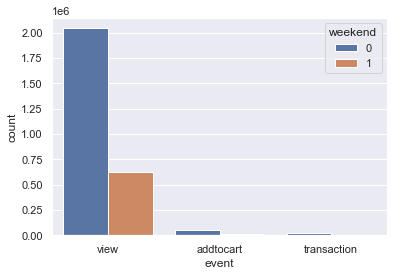

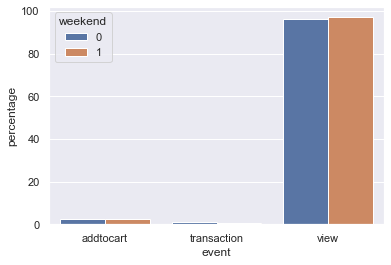

In [66]:
sns.countplot(x="event", hue="weekend", data=df);
plt.show()

# faire analyse en proportion est mieux car 5 jours hors semine contre  2 jour en week-end => graph déséquilibré !!

graph = (df.groupby(['weekend'])['event']
         .value_counts(normalize=True)
         .rename('percentage')
         .mul(100)
         .reset_index()
         .sort_values('event'))
         
p = sns.barplot(x='event', y='percentage', hue='weekend', data = graph);

graph = plt.setp(p.get_xticklabels(), rotation=0);
plt.show()
# graph + pertinent car %

Text(0, 0.5, 'number of transaction')

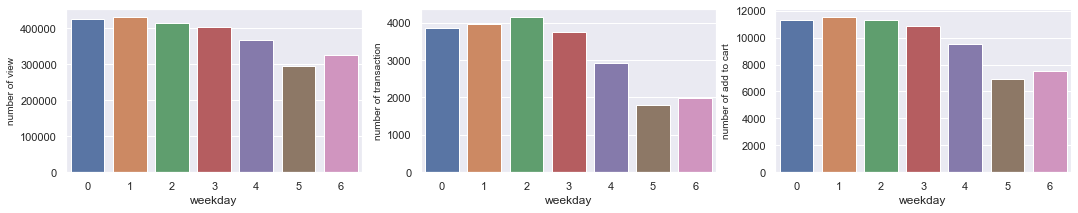

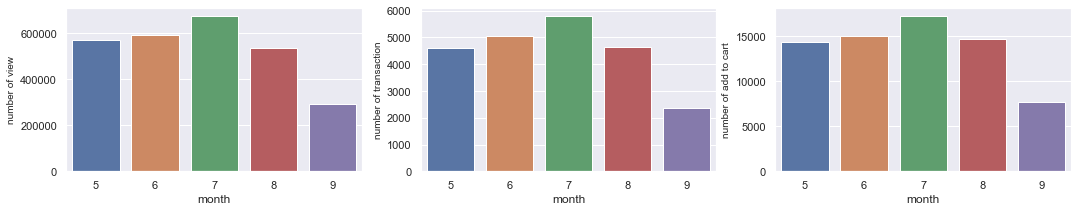

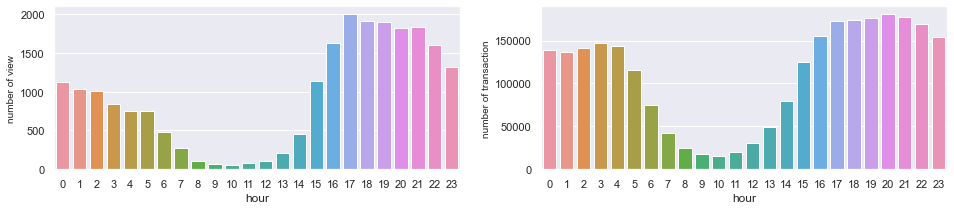

In [67]:
sns.set_theme()

f, axes = plt.subplots(1, 3, figsize=(18,3))
ax1 = sns.countplot(x='weekday', data=df.loc[df['event'] == "view", ['event', 'weekday']], ax=axes[0] )
ax1.set_ylabel("number of view", size = 10)
ax2 = sns.countplot(x='weekday', data = df.loc[df['event'] == "transaction", ['event', 'weekday']], ax=axes[1] )
ax2.set_ylabel("number of transaction", size = 10)
ax3 = sns.countplot(x='weekday', data = df.loc[df['event'] == "addtocart", ['event', 'weekday']], ax=axes[2] )
ax3.set_ylabel("number of add to cart", size = 10)

f, axes = plt.subplots(1, 3, figsize=(18,3))
ax1 = sns.countplot(x='month', data=df.loc[df['event'] == "view", ['event', 'month']], ax=axes[0] )
ax1.set_ylabel("number of view", size = 10)
ax2 = sns.countplot(x='month', data = df.loc[df['event'] == "transaction", ['event', 'month']], ax=axes[1] )
ax2.set_ylabel("number of transaction", size = 10)
ax3 = sns.countplot(x='month', data = df.loc[df['event'] == "addtocart", ['event', 'month']], ax=axes[2] )
ax3.set_ylabel("number of add to cart", size = 10)

f, axes = plt.subplots(1, 2, figsize=(16,3))
ax1 = sns.countplot(x='hour', data=df.loc[df['event'] == "transaction", ['event', 'hour']], ax=axes[0] )
ax1.set_ylabel("number of view", size = 10)
ax2 = sns.countplot(x='hour', data = df.loc[df['event'] == "view", ['event', 'hour']], ax=axes[1] )
ax2.set_ylabel("number of transaction", size = 10)




### ajout de colonnes autre df sur les produits

In [68]:
item_1 = pd.read_csv("item_properties_part1.csv")

In [69]:
item_2 = pd.read_csv("item_properties_part2.csv")

In [70]:
tree = pd.read_csv("category_tree.csv")

In [71]:
# on concatene item 1 et 2 sur les lignes car memes colonnes
item = pd.concat([item_1, item_2], axis=0)

In [72]:
print(df.columns)
print(item.columns)
print(tree.columns)

Index(['timestamp', 'visitorid', 'event',
       'itemid', 'transactionid', 'month',
       'weekday', 'weekend', 'day', 'hour'],
      dtype='object')
Index(['timestamp', 'itemid', 'property',
       'value'],
      dtype='object')
Index(['categoryid', 'parentid'], dtype='object')


### analyse des 3 autres jeux de données

- entre df et titem 2 variables communes : itemid et timestamp => info produits
- variable 'property' et 'value' rensignent sur la disponibilité => clé de jointure entre 1er jue de donnée et les nouveaux
- nous construisons donc 2 nouveaux dataframes : 1 pour avaibility et 1 pour categoryid des produits
- on considérera aussi la variable temps qui peut influencer sur la disponibilité des produits

In [73]:
item

,timestamp,itemid,property,value
0,1435460400000,460429,categoryid,1338
1,1441508400000,206783,888,1116713 960601 n277.200
2,1439089200000,395014,400,n552.000 639502 n720.000 424566
3,1431226800000,59481,790,n15360.000
4,1431831600000,156781,917,828513
...,...,...,...,...
9275898,1433646000000,236931,929,n12.000
9275899,1440903600000,455746,6,150169 639134
9275900,1439694000000,347565,686,610834
9275901,1433646000000,287231,867,769062


- on voit que
- le timestamps ici devrait etre la dispo au temps t du produit itemid
- dans property on a categoryid ou  des numeros
- dans value il y a le n° de la categoryid


In [74]:
# etape 1 : on supprime les itemid qui sont presents dans le nouveau dataframe et pas dans l'ancien
# puis on fait de meme pour df ( verif au prealable )

item = item[item['itemid'].isin(df['itemid'])]

df = df[df['itemid'].isin(item['itemid'])]

In [75]:
# etape 2 : obtention des 2 new dataframes

item_availability = item.loc[item.property == 'available'].sort_values(by='itemid')

item_categoryid = item.loc[item.property == 'categoryid'].sort_values(by='itemid')


In [76]:
# etape 3 : jointures

merged_1 = pd.merge_asof(df.sort_values(by='timestamp'),
                                        item_availability.sort_values(by='timestamp'),
                                        on='timestamp',
                                        by='itemid',
                                        direction='nearest').sort_values(by='itemid')

In [77]:
merged_2 = pd.merge_asof(merged_1.sort_values(by='timestamp'),
                                        item_categoryid.sort_values(by='timestamp'),
                                        on='timestamp',
                                        by='itemid',
                                        direction='nearest').sort_values(by='itemid')

In [78]:
data = merged_2.rename(columns={'value_x':'available', 'value_y':'categoryid'}).drop(['property_x', 'property_y'], axis=1)

In [79]:
data['categoryid'] = data['categoryid'].astype(float)

data = pd.merge(data, tree, how='left', on='categoryid')

In [80]:
data.head()

,timestamp,visitorid,event,itemid,transactionid,month,weekday,weekend,day,hour,available,categoryid,parentid
0,1439922640493,370720,view,3,NaN,8,1,0,18,18,0,1171.0,938.0
1,1441031942792,639016,view,3,NaN,8,0,0,31,14,0,1171.0,938.0
2,1441044360244,905555,view,4,NaN,8,0,0,31,18,0,1038.0,1174.0
3,1435647791545,1042455,view,4,NaN,6,1,0,30,7,0,1038.0,1174.0
4,1442359364099,1010132,view,4,NaN,9,1,0,15,23,0,1038.0,1174.0


### tranformation de notre dataframe pour modelisation
- maintenant qu'on a un dataframe + riche, on va essayer de le transformer pour obtenir un df utilisable pour 1 modelisation

In [81]:
data[['addtocart', 'transaction', 'view']] = pd.get_dummies(data['event'])

aggregation = {'addtocart':'sum',
               'transaction':'sum',
               'view':'sum',
               'available':pd.Series.mode,
               'categoryid':'first',
               'parentid':'first',
               'month':'nunique',
               'visitorid':'nunique'}

item_data = data.groupby('itemid').agg(aggregation)

### quelques analyses graphiques supplémentaires

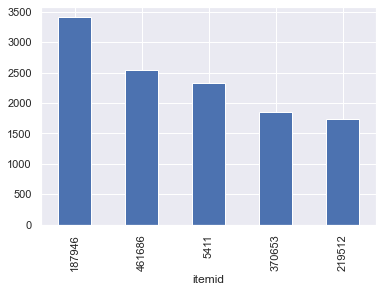

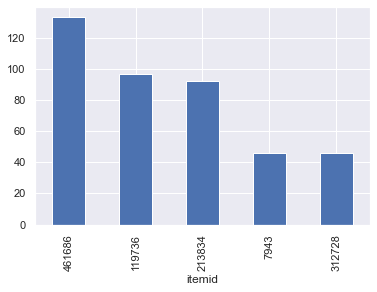

In [82]:
df2 = item_data[['addtocart','transaction','view']]

df2['view'].nlargest(n=5).plot.bar()
plt.show()

df2['transaction'].nlargest(n=5).plot.bar()
plt.show()

### modelisation et target
- la colonne qu'on va pouvoir prédire est la colonne 'transaction', on cherche à déterminer si un produit s'est vendu ou non et quelles sont les caractéristiques qui détermine cela

In [83]:
item_data['available'] = item_data['available'].apply(lambda x : x[0]).astype(int)

item_data['target'] = np.where(item_data['transaction'] > 0, 1, 0)

item_data_reg = item_data.drop('target', axis=1)

item_data_class = item_data.drop('transaction', axis=1)

### regression

In [84]:
from sklearn.model_selection import train_test_split
from sklearn.ensemble import GradientBoostingRegressor

In [87]:
X = item_data_reg.drop('transaction', axis=1)

y = item_data_reg['transaction']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

model = GradientBoostingRegressor()
model.fit(X_train, y_train)

model.score(X_test, y_test)

0.5186179510121034

- on obtient un score mitigé, on va essayer une clmassification

### classification

In [88]:
item_data_class

,addtocart,view,available,categoryid,parentid,month,visitorid,target
itemid,,,,,,,,
3,0.0,2.0,0,1171.0,938.0,1,2,0
4,0.0,3.0,0,1038.0,1174.0,3,3,0
6,0.0,29.0,1,1091.0,573.0,4,26,0
15,3.0,18.0,1,722.0,1110.0,3,13,1
16,0.0,15.0,0,333.0,1497.0,5,14,0
...,...,...,...,...,...,...,...,...
466858,0.0,6.0,1,1191.0,61.0,4,6,0
466861,5.0,89.0,1,1051.0,955.0,5,76,1
466862,0.0,4.0,0,1376.0,480.0,3,4,0


In [89]:
X = item_data_class.drop('target', axis=1)

y = item_data_class['target']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

from sklearn.ensemble import GradientBoostingClassifier
from sklearn.metrics import accuracy_score, f1_score, classification_report, confusion_matrix

model = GradientBoostingClassifier()
model.fit(X_train, y_train)

y_pred = model.predict(X_test)

print(accuracy_score(y_pred, y_test))
print(f1_score(y_pred, y_test))
print(classification_report(y_pred, y_test))
print(confusion_matrix(y_pred, y_test))


0.9611336032388664
0.6704805491990847
              precision    recall  f1-score   support

           0       0.98      0.97      0.98     35021
           1       0.63      0.72      0.67      2029

    accuracy                           0.96     37050
   macro avg       0.80      0.85      0.82     37050
weighted avg       0.96      0.96      0.96     37050

[[34145   876]
 [  564  1465]]


### analyse des scores de prediction
- on remarque quie les scores sont déséquilibrés entre la classe nulle et la classe positive.
- on cherche alors à identifier ce qu'on cherche à obtenir avec notre modèle

Rappel sur l'interpretation :
- la precision du model sur la classe positive : parmi tous les porduits pour lesquels il y a eu une transaction qui sont predits par le modele, combien sont de vraies transactions ?

- le rappel du model sur la classe positive : parmi tous les porduits pour lesquels il y a eu une transaction qui sont predits par le modele, combien ont été correctement par le modele

Ici on souhaite maximiser le rappel, nous allons tenter de realiser du resampling : ici de l'undersampling

In [91]:
from imblearn.under_sampling import RandomUnderSampler

In [92]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

rUs = RandomUnderSampler()

X_ru, y_ru = rUs.fit_resample(X_train, y_train)

print('classes échantillons undersampled :', dict(pd.Series(y_ru).value_counts()))

model.fit(X_ru, y_ru)

y_pred = model.predict(X_test)

print(accuracy_score(y_pred, y_test))
print(f1_score(y_pred, y_test))
print(classification_report(y_pred, y_test))
print(confusion_matrix(y_pred, y_test))



classes échantillons undersampled : {0: 9304, 1: 9304}
0.9320647773279352
0.6437367303609342
              precision    recall  f1-score   support

           0       0.93      1.00      0.96     32326
           1       0.97      0.48      0.64      4724

    accuracy                           0.93     37050
   macro avg       0.95      0.74      0.80     37050
weighted avg       0.93      0.93      0.92     37050

[[32259    67]
 [ 2450  2274]]


 ### on a une tres bonne precision mais pas un bon recall sur la classe positive...stop ici